In [7]:
import tensorflow as tf
import glob
import os
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt

## Create TFRecord File

In [11]:
def _bytes_feature(value):
    """Convert string / byte in bytes_list."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Convert float / double in float_list."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Convert bool / enum / int / uint in int64_list."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
# Create a dictionary with relevant features
def image_example(image_label, image_string):
    image_shape = tf.image.decode_png(image_string).shape

    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'image': _bytes_feature(image_string),
      'label': _int64_feature(image_label)
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [13]:
# Filename 
record_file = 'dataset/mnist_ds_tpu.tfrecords'
path_to_folders = 'dataset/mnist-normal/train/'

# Folder names
labels_list = sorted(os.listdir(path_to_folders))

with tf.io.TFRecordWriter(record_file) as writer:
    for label in tqdm(labels_list):
        filenames = glob.glob(f"{path_to_folders}{label}/*.png")
        for filename in filenames:
            image_string = open(filename, 'rb').read()
            # Convert labels and image in `tf.Example`- message
            tf_example = image_example(int(label), image_string)
            # Then write in '.tfrecords' file 
            writer.write(tf_example.SerializeToString())

100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


## Check File 

In [14]:
# Create dict with encoded features
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

In [15]:
def show_dataset(tfrecord_file, features_description, batch_size=4):

    image_dataset = tf.data.TFRecordDataset(tfrecord_file)

    # Augmentation
    def _parse_image_function(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        feature = tf.io.parse_single_example(example_proto, features_description)
        image = feature['image']
        image = tf.image.decode_png(image, channels=3)
        label = feature['label']  
        return image, label

    dataset = image_dataset.map(_parse_image_function, num_parallel_calls=multiprocessing.cpu_count())
    dataset = dataset.shuffle(128)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=2) # Next Iteration Cache
    
    return dataset

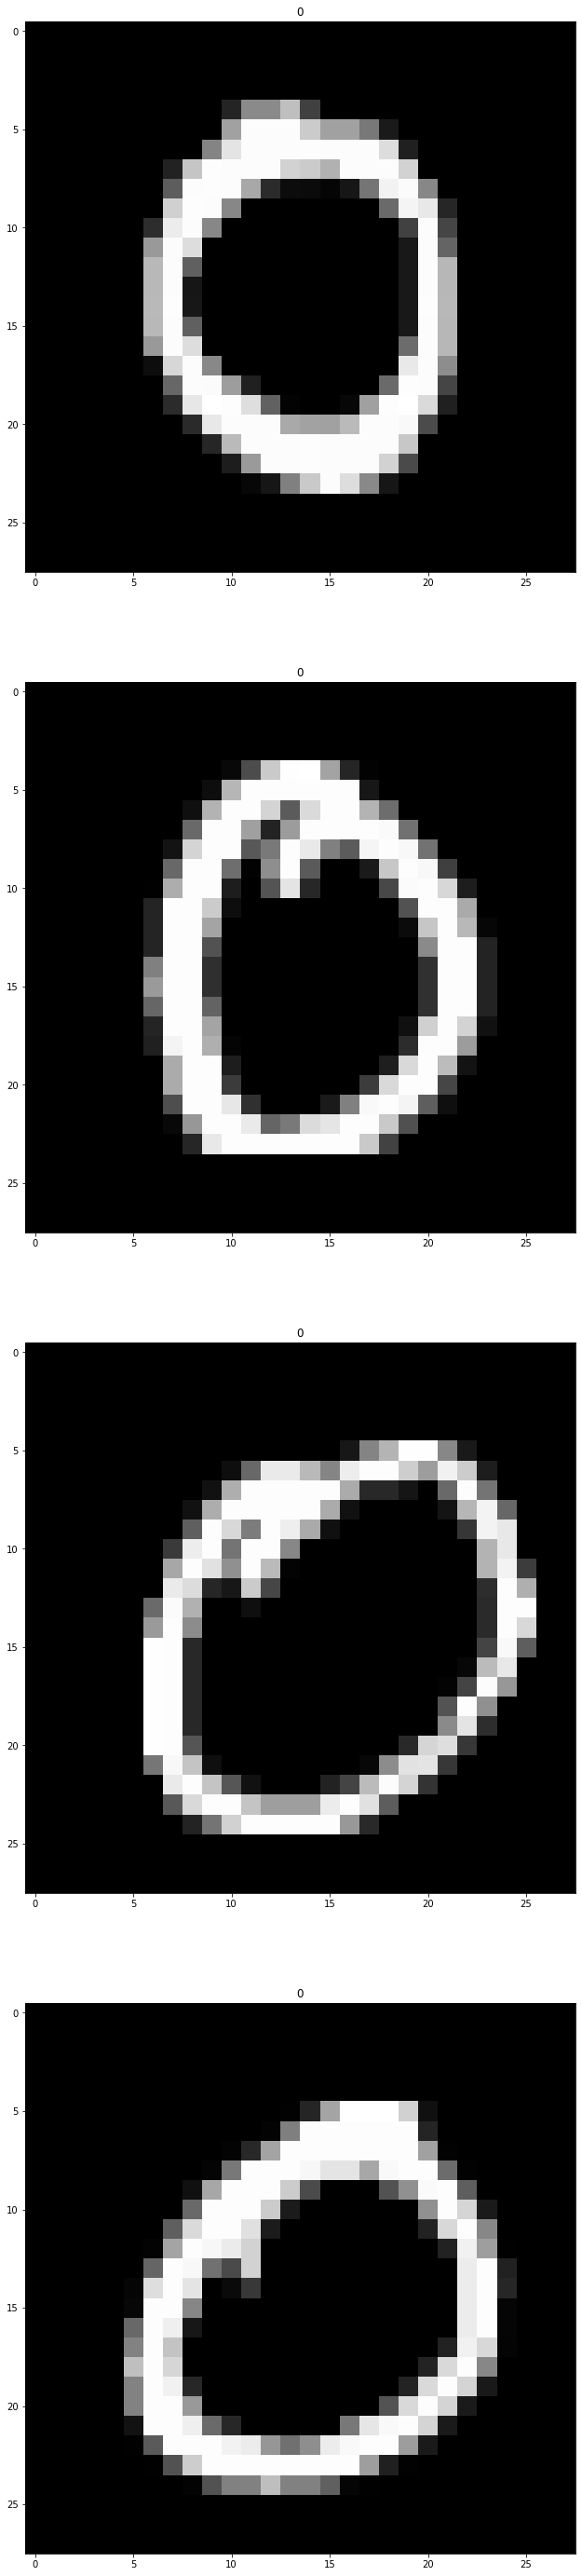

In [22]:
dataset = show_dataset(record_file, image_feature_description)

fig = plt.figure(figsize=(50, 50))  # width, height in inches

for image, label in dataset.unbatch().batch(4).take(1):
    for i in range(4):
        img_show = tf.cast(image, tf.int32)
        sub = fig.add_subplot(4, 1, i + 1)
        sub.title.set_text(str(label[i].numpy()))
        sub.imshow(img_show[i].numpy(), interpolation='nearest')